In [1]:
# Magic + imports likely common across all notebooks
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')
# Set reference for util modules
#import sys
#sys.path.append('/home/jovyan/odc-hub/')
# Generic python
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr 
import odc.algo

# Bonus vector manipulation
import pandas as pd
import geopandas as gpd
from shapely import wkt
from datetime import datetime
import datacube

import dask

CMAP = "Blues"

https://www.tandfonline.com/doi/abs/10.1080/15481603.2014.939539
https://www.tandfonline.com/doi/pdf/10.1080/01431161.2010.481681

# Urbanisation

** ADD description

In [2]:
!pip install git+https://github.com/SatelliteApplicationsCatapult/datacube-utilities.git#egg=datacube_utilities

In [3]:
dc = datacube.Datacube(app = 'land_degredation')#, config = '/home/localuser/.datacube.conf')

from matplotlib.cm import RdYlGn, Greens
from odc.algo import to_f32, from_float, xr_geomedian
from datacube_utilities.dc_load import get_product_extents
from datacube_utilities.dc_time import dt_to_str
from datacube_utilities.dc_display_map import display_map
from datacube_utilities.dc_mosaic import create_max_ndvi_mosaic, create_median_mosaic, create_mosaic
from datacube_utilities.dc_rgb import rgb
from datacube_utilities.createAOI import create_lat_lon
from datacube_utilities.dc_water_classifier import wofs_classify
from datacube_utilities.createindices import NDVI
from datacube_utilities.fromDCALscripts import threshold_plot
from datacube_utilities.dc_utilities import write_geotiff_from_xr
from datacube_utilities.clean_mask import landsat_qa_clean_mask
from datacube_utilities.dc_fractional_coverage_classifier import frac_coverage_classify 
from datacube_utilities.dc_utilities import write_geotiff_from_xr
from datacube_utilities.import_export import export_xarray_to_multiple_geotiffs



In [4]:
RdYlGn.set_bad('black',1.)
Greens.set_bad('black',1.)

## Set Variables

In [5]:
#inputs
#options "LANDSAT_8", "LANDSAT_7", "LANDSAT_5", "LANDSAT_4" and "SENTINEL_2"
platform_base = "LANDSAT_8"
platform_analysis = "LANDSAT_8"
#For Fiji this should be the only option - may change for Solomon and Vanuatu
output_projection = "EPSG:3460"
crs = "EPSG:3460"
res = (30)

# Select the start and end periods for your analysis products
# The datetime function is (Year,Month,Day)
# These time windows will be used to make a mosaic, so typically pick a year length or more
# Be sure to evaluate the RGB mosaics to affirm they are not full of clouds

#set baseline start and end of period
baseline_start_date = '2013-1-1'
baseline_end_date = '2017-12-1'

#set the analysis start and end of period
#analysis_start_date = '2017-1-1'
#analysis_end_date = '2017-12-1'

# If a geomedian is selected, it will take much longer to process

# options are "median" or "geomedian"
#mosaic_type = "geomedian" # change this to geomedian 

#define AOI
#central area - do dates 2013- 2014 and 2018-2019
#aoi_wkt = "POLYGON ((177.42576599121094 -18.058395415674948, 177.5390625 -18.058395415674948, 177.5390625 -17.96567026450931, 177.42576599121094 -17.96567026450931, 177.42576599121094 -18.058395415674948))"
# wakaya island - hit by cyclone winston in feb 2016  - dates end of JAn 2015-2016, start of March 2016 - 2017
#ai_wkt = "POLYGON((178.98101806642 -17.592544555664, 179.03903961183 -17.593231201171, 179.03903961183 -17.66258239746, 178.97998809815 -17.661209106445, 178.98101806642 -17.592544555664))"
#aoi_wkt = "POLYGON((179.4389622562436 -16.668794626017938,179.51758316688813 -16.668794626017938,179.51758316688813 -16.734562495004166,179.4389622562436 -16.734562495004166,179.4389622562436 -16.668794626017938))"
#aoi_wkt = "POLYGON((179.34386185341157 -16.511847130448928,179.73662308388032 -16.511847130448928,179.73662308388032 -16.83810084556268,179.34386185341157 -16.83810084556268,179.34386185341157 -16.511847130448928))"
aoi_wkt = "POLYGON((178.39699689321165 -18.061332095979633,178.55080548696165 -18.061332095979633,178.55080548696165 -18.18467000208122,178.39699689321165 -18.18467000208122,178.39699689321165 -18.061332095979633))"

## create AOI

In [6]:
lat_extents, lon_extents = create_lat_lon(aoi_wkt)

In [7]:
## The code below renders a map that can be used to orient yourself with the region.
display_map(latitude = lat_extents, longitude = lon_extents)

In [8]:
from pyproj import Proj, transform
inProj  = Proj("+init=EPSG:4326")
outProj = Proj("+init=EPSG:3460")

In [9]:
min_lat, max_lat = (lat_extents) 
min_lon, max_lon = (lon_extents)

In [10]:
x_A, y_A = transform(inProj, outProj, min_lon, min_lat)
x_B, y_B = transform(inProj, outProj, max_lon, max_lat)

In [11]:
lat_range = (y_A, y_B)
lon_range = (x_A, x_B)

In [12]:
print(lat_range)

(3868865.296636806, 3882539.0512192366)


In [13]:
print(lon_range)

(1962643.4711290102, 1978898.4636792026)


## Translate inputs and load data

In [14]:
allmeasurements = ["green","red","blue","nir","swir1","swir2"]
#water_measurements = ["water_classification"]
def create_product_measurement(platform):
    if platform  in ["SENTINEL_2"]:
        product = 's2_esa_sr_granule'
        measurements = allmeasurements + ["coastal_aerosol","scene_classification"]
        ###CHANGE WHEN S2 WOFS READY
        water_product = 'SENTINEL_2_PRODUCT DEFS'
    elif platform in ["LANDSAT_8"]:    
        measurements = allmeasurements
        product = 'ls8_geomedian_annual'
        #water_product = 'ls8_water_classification'
    elif platform in ["LANDSAT_7"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls7_geomedian_annual'
        water_product = 'ls7_water_classification'
    elif platform in ["LANDSAT_5"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls5_usgs_sr_scene'
        water_product = 'ls5_water_classification'
    elif platform in ["LANDSAT_4"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls4_usgs_sr_scene'
        water_product = 'ls4_water_classification'
    else:
        print("invalid platform")
    return product

In [15]:
#baseline_product, baseline_measurement = create_product_measurement(platform_base)
#analysis_product, analysis_measurement = create_product_measurement(platform_analysis)

In [16]:
baseline_product = create_product_measurement(platform_base)
analysis_product = create_product_measurement(platform_analysis)

In [17]:
#create resolution
resolution = (-res, res)

In [18]:
dask_chunks = dict(
    x = 1000,
    y = 1000
)

In [19]:
x_extents = (2050000.0, 2150000.0)
y_extents = (3999700.0, 4100300.0)

In [20]:
#lon_range = (2063266.0, 2105301.0)
#lat_range = (4017815.0, 4053752.0)

In [21]:
#lon_range = (2050000.0, 2150000.0)
#lat_range = (3999700.0, 4100300.0)

In [22]:
x_extents = (2033081.0, 2133081.0)
y_extents = (3999700.0, 4100300.0)

In [23]:
#x_extents = (2115000.0, 2160000.0)
#y_extents = (3995000.0, 4040000.0)

In [24]:
#format dates
def createDate(inputStart, inputEnd):
    start = datetime.strptime(inputStart, '%Y-%m-%d')
    end = datetime.strptime(inputEnd, '%Y-%m-%d')
    startDates = start.date()
    endDates = end.date()
    time_period = (startDates, endDates)
    return time_period

baseline_time_period = createDate(baseline_start_date, baseline_end_date)
#analysis_time_period = createDate(analysis_start_date, analysis_end_date)

In [25]:
# Create the 'query' dictionary object, which contains the longitudes, latitudes 
query = {
    'y': lat_range,
    'x': lon_range,
    #'y': y_extents,
    #'x': x_extents,
    'output_crs': output_projection,  
    'resolution': resolution,
    'dask_chunks': dask_chunks
}


In [26]:
baseline_ds = dc.load(
    #time = 2017,
    time = baseline_time_period,
    #measurements = baseline_measurement,
    product = baseline_product,
    platform = platform_base,
    crs = crs,
    **query
)


In [27]:
analysis_ds = dc.load(
    time = analysis_time_period,
    measurements = analysis_measurement,
    product = analysis_product,
    platform = platform_analysis,
    crs = crs,
    **query
)

NameError: name 'analysis_time_period' is not defined

> #### Check if loads are valid

In [28]:
def is_dataset_empty(ds:xr.Dataset) -> bool:
    checks_for_empty = [
                        lambda x: len(x.dims) == 0,      #Dataset has no dimensions
                        lambda x: len(x.data_vars) == 0  #Dataset no variables 
                       ]
    for f in checks_for_empty:
         if f(ds) == True:
                return True
    return False

In [29]:
if is_dataset_empty(baseline_ds): raise Exception("DataCube Load returned an empty Dataset." +  
                                               "Please check load parameters for Baseline Dataset!")

In [30]:
print(baseline_ds)

<xarray.Dataset>
Dimensions:  (time: 5, x: 543, y: 456)
Coordinates:
  * time     (time) datetime64[ns] 2013-07-02 2014-07-02 ... 2017-07-02
  * y        (y) float64 3.883e+06 3.882e+06 3.882e+06 ... 3.869e+06 3.869e+06
  * x        (x) float64 1.963e+06 1.963e+06 1.963e+06 ... 1.979e+06 1.979e+06
Data variables:
    blue     (time, y, x) int16 dask.array<chunksize=(1, 456, 543), meta=np.ndarray>
    green    (time, y, x) int16 dask.array<chunksize=(1, 456, 543), meta=np.ndarray>
    red      (time, y, x) int16 dask.array<chunksize=(1, 456, 543), meta=np.ndarray>
    nir      (time, y, x) int16 dask.array<chunksize=(1, 456, 543), meta=np.ndarray>
    swir1    (time, y, x) int16 dask.array<chunksize=(1, 456, 543), meta=np.ndarray>
    swir2    (time, y, x) int16 dask.array<chunksize=(1, 456, 543), meta=np.ndarray>
Attributes:
    crs:      EPSG:3460


In [31]:
#baseline_ds.red.plot(col='time', cmap='Greens', col_wrap=3)


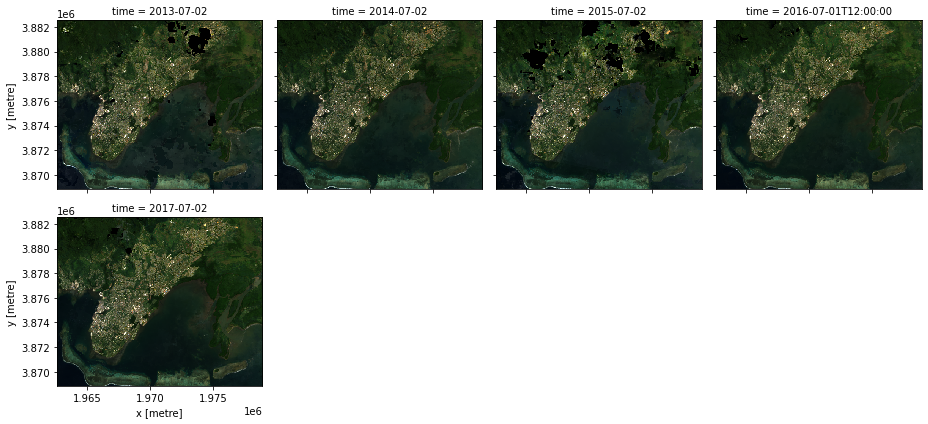

In [32]:
baseline_ds[['red','green','blue']].to_array().plot.imshow(
    x=baseline_ds.crs.dimensions[1],
    y=baseline_ds.crs.dimensions[0],
    col='time',
    #figsize=(20, 20),
    vmin=0,
    vmax=3000,
    col_wrap=4,
    #add_colorbar=False
)

In [33]:
#baseline_ds_2 = baseline_ds.compute()

In [34]:
#print(baseline_ds_2)

## Calculate NDBI

In [158]:
from datacube_utilities.createindices import NDVI, NDWI, NDBI

In [36]:
#ndbi_base = NDBI(baseline_ds_2)  # Urbanization

In [37]:
def NDBI(dataset):
    return (dataset.swir1 - dataset.nir)/(dataset.swir1 + dataset.nir)

In [38]:
def MNDWI(dataset):
    return (dataset.green - dataset.swir2)/(dataset.green + dataset.swir2)

In [222]:
mndwi_base = MNDWI(baseline_ds)

In [160]:
ndbi_base = NDBI(baseline_ds)

In [44]:
ndvi_base = NDVI(baseline_ds)

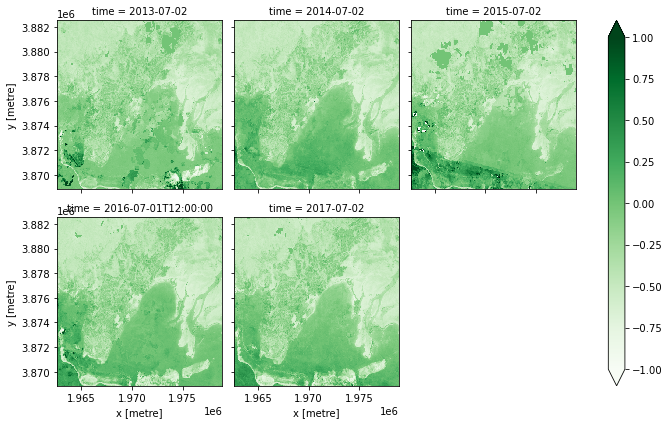

In [41]:
ndbi_base.plot(col='time', cmap='Greens', col_wrap=3, vmin =-1, vmax = 1)

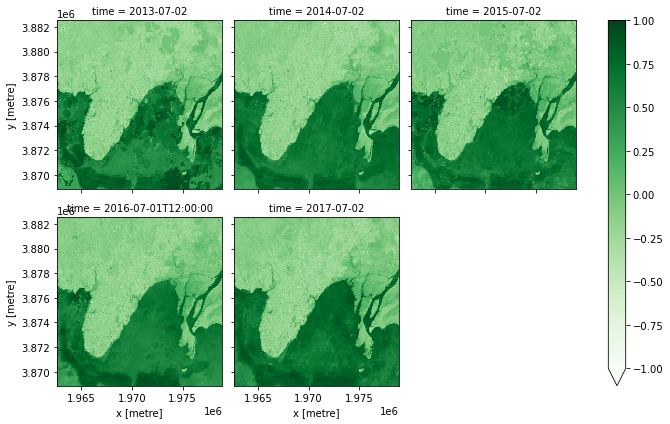

In [42]:
mndwi_base.plot(col='time', cmap='Greens', col_wrap=3, vmin =-1, vmax = 1)

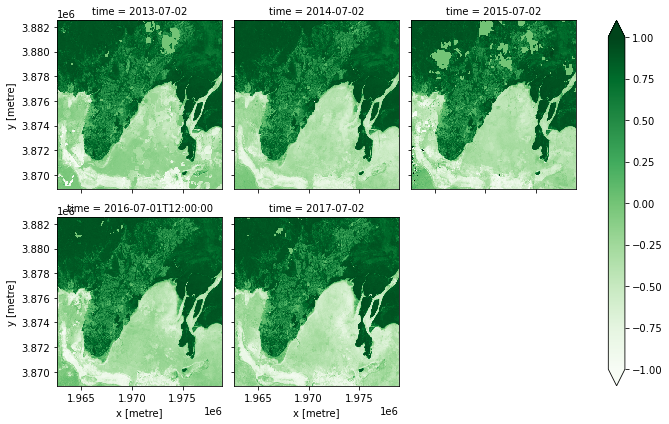

In [45]:
ndvi_base.plot(col='time', cmap='Greens', col_wrap=3, vmin =-1, vmax = 1)

In [46]:
#ndvi_base = NDVI(baseline_ds)  # Urbanization

In [223]:
BU_index1 = (ndbi_base) - (mndwi_base) - (ndvi_base)
#BU_index1 = ndbi_base - ndvi_base

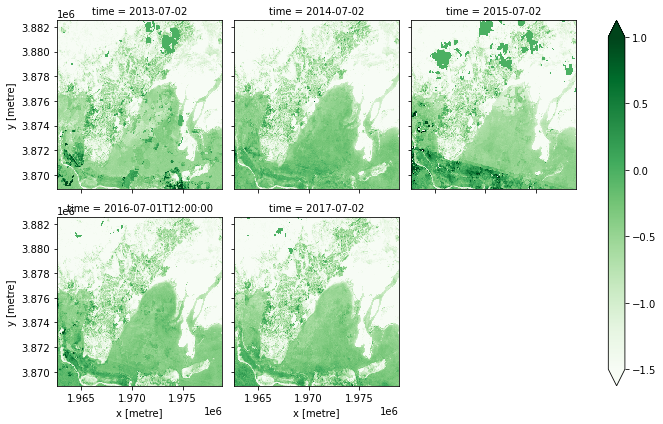

In [224]:
BU_index1.plot(col='time', cmap='Greens', col_wrap=3, vmin =-1.5, vmax = 1)

In [225]:
#BU_index = BU_index1

In [226]:
print(ndbi_base.time.dt.year)

<xarray.DataArray 'year' (time: 5)>
array([2013, 2014, 2015, 2016, 2017])
Coordinates:
  * time     (time) datetime64[ns] 2013-07-02 2014-07-02 ... 2017-07-02


In [227]:
#ndbi_base.time = ndbi_base.time.dt.year

In [228]:
BU_index = BU_index1.compute()

In [229]:
BU_index = xr.DataArray.to_dataset(BU_index, name = 'ndbi')

In [230]:
#write_geotiff_from_xr('test.tiff', ndbi_ds, crs=output_projection, x_coord = 'x', y_coord = 'y')

In [231]:
#print(ndbi_base)

In [232]:
export_xarray_to_multiple_geotiffs(BU_index, 'urban_out/annual', x_coord='x', y_coord='y')

In [233]:
#up to here now bring in each tiff seperately - iterate through them getting mean

In [234]:
#bands=list(ndbi_ds.data_vars.keys())

In [235]:
#print(bands)

In [236]:
#(ndbi_base).plot(cmap = "Reds", vmin = -1, vmax = 0)
#ndbi_base.plot(col='time', cmap='Reds', col_wrap=3, vmin = -1, vmax = 0)

In [237]:
import geopandas
shpFile = geopandas.read_file("urbanisation/Urban_suva.shp", driver='shapefile')

In [238]:
rasterTiff = 'test.tiff'

In [239]:
print(shpFile)

    id                                           geometry
0    1  POLYGON ((1975434.206 3880672.745, 1974116.203...
1    2  POLYGON ((1971055.542 3876087.419, 1970715.190...
2    3  POLYGON ((1969744.033 3878330.420, 1970296.786...
3    5  POLYGON ((1965488.344 3872081.237, 1965923.382...
4   11  POLYGON ((1969561.932 3875485.463, 1969879.219...
5   12  POLYGON ((1966282.265 3874791.787, 1966384.398...
6   13  POLYGON ((1967033.488 3875031.048, 1967160.247...
7   14  POLYGON ((1968435.875 3873987.941, 1968581.039...
8    6  POLYGON ((1967332.629 3874176.654, 1967712.129...
9    7  POLYGON ((1966380.769 3874271.011, 1966553.929...
10  15  POLYGON ((1969392.920 3873588.741, 1969674.953...
11   9  POLYGON ((1967451.871 3875851.224, 1967621.920...
12  16  POLYGON ((1968095.608 3872134.415, 1968184.223...


In [240]:
from rasterstats import zonal_stats

In [241]:
createData = zonal_stats(shpFile, rasterTiff, stats= 'mean', geojson_out=True)

In [242]:
#set directory paths
import os, gc, glob
import rasterstats as rs
from geopandas import GeoDataFrame
#inputShp = "/home/s1333131/dissertation/shapefiles/all_bufer_20/outline-buffer/all_together.shp"
inputShp = "urbanisation/Urban_suva.shp"
path = "urban_out/"
#odc-hub/devenvironment/urban_out/annaul_2013_07_02_00_00_00.tif
#put shapefile into a geodataframe
geodf = gpd.read_file(inputShp)
print(geodf)
dataGDF = gpd.GeoDataFrame(geodf)

#get each file from the directory
for folder in os.listdir(path):
        fileSafe = path + folder
        base = os.path.basename(fileSafe)
        base2 = os.path.splitext(base)[0]
        timestamp = base2.split("_")[1]
        if base2 in ".ipynb_checkpoints":
            print("invalid file")
        else:
            geodf2 = gpd.read_file(inputShp)
            #print(geodf2)
            #calculate statistics from the raster for each shapefile
            createData = rs.zonal_stats(geodf2, fileSafe, prefix=timestamp + '_', stats= 'mean', geojson_out=True)  
            #create a geodataframe of the statistics.
            zonalGDF2 = GeoDataFrame.from_features(createData)
            #append zonal statistics to the shapefile geodataframe
            dataGDF = zonalGDF2.append(dataGDF,sort=True)
            dataGDFnew = dataGDF.groupby(dataGDF.index).max()
            dataGDFn = gpd.GeoDataFrame(dataGDFnew)
print(dataGDFn)

    id                                           geometry
0    1  POLYGON ((1975434.206 3880672.745, 1974116.203...
1    2  POLYGON ((1971055.542 3876087.419, 1970715.190...
2    3  POLYGON ((1969744.033 3878330.420, 1970296.786...
3    5  POLYGON ((1965488.344 3872081.237, 1965923.382...
4   11  POLYGON ((1969561.932 3875485.463, 1969879.219...
5   12  POLYGON ((1966282.265 3874791.787, 1966384.398...
6   13  POLYGON ((1967033.488 3875031.048, 1967160.247...
7   14  POLYGON ((1968435.875 3873987.941, 1968581.039...
8    6  POLYGON ((1967332.629 3874176.654, 1967712.129...
9    7  POLYGON ((1966380.769 3874271.011, 1966553.929...
10  15  POLYGON ((1969392.920 3873588.741, 1969674.953...
11   9  POLYGON ((1967451.871 3875851.224, 1967621.920...
12  16  POLYGON ((1968095.608 3872134.415, 1968184.223...
invalid file
    2013_mean  2014_mean  2015_mean  2016_mean  2017_mean  id
0   -0.857452  -0.921817  -0.992656  -0.979747  -0.929742   1
1   -0.507055  -0.448613  -0.480783  -0.466932  -0.

In [243]:
#df3 = pd.merge(geodf, dataGDFn, left_index=True, right_index=True)
df3 = pd.merge(geodf, dataGDFn, on='id')

In [244]:
df4 = df3.set_index('id')

In [245]:
print(df4)

                                             geometry  2013_mean  2014_mean  \
id                                                                            
1   POLYGON ((1975434.206 3880672.745, 1974116.203...  -0.857452  -0.921817   
2   POLYGON ((1971055.542 3876087.419, 1970715.190...  -0.507055  -0.448613   
3   POLYGON ((1969744.033 3878330.420, 1970296.786...  -0.862662  -0.880882   
5   POLYGON ((1965488.344 3872081.237, 1965923.382...  -0.835836  -0.874615   
11  POLYGON ((1969561.932 3875485.463, 1969879.219...  -1.338687  -1.413637   
12  POLYGON ((1966282.265 3874791.787, 1966384.398...  -1.442834  -1.396279   
13  POLYGON ((1967033.488 3875031.048, 1967160.247...  -1.150789  -1.197831   
14  POLYGON ((1968435.875 3873987.941, 1968581.039...  -1.756088  -1.827193   
6   POLYGON ((1967332.629 3874176.654, 1967712.129...  -0.708746  -0.796047   
7   POLYGON ((1966380.769 3874271.011, 1966553.929...  -0.726382  -0.777702   
15  POLYGON ((1969392.920 3873588.741, 1969674.953..

In [246]:
df5 = df4.drop('geometry', axis=1)

In [247]:
print(df5)

    2013_mean  2014_mean  2015_mean  2016_mean  2017_mean
id                                                       
1   -0.857452  -0.921817  -0.992656  -0.979747  -0.929742
2   -0.507055  -0.448613  -0.480783  -0.466932  -0.382107
3   -0.862662  -0.880882  -0.958559  -0.854835  -0.807801
5   -0.835836  -0.874615  -0.977641  -0.922362  -0.880090
11  -1.338687  -1.413637  -1.447596  -1.369492  -1.411030
12  -1.442834  -1.396279  -1.221262  -1.371959  -1.374505
13  -1.150789  -1.197831  -1.127977  -1.116554  -1.161786
14  -1.756088  -1.827193  -1.828648  -1.824389  -1.846621
6   -0.708746  -0.796047  -0.807445  -0.748521  -0.733526
7   -0.726382  -0.777702  -0.812070  -0.760291  -0.732334
15  -0.598128  -0.474874  -0.637699  -0.418537  -0.450670
9   -0.767204  -0.820300  -0.821324  -0.770537  -0.692430
16  -0.597402  -0.472389  -0.765685  -0.436277  -0.443663


In [248]:
df6 = df5.T

In [249]:
df7 = pd.DataFrame(df6)

In [250]:
print(df7)

id               1         2         3         5         11        12  \
2013_mean -0.857452 -0.507055 -0.862662 -0.835836 -1.338687 -1.442834   
2014_mean -0.921817 -0.448613 -0.880882 -0.874615 -1.413637 -1.396279   
2015_mean -0.992656 -0.480783 -0.958559 -0.977641 -1.447596 -1.221262   
2016_mean -0.979747 -0.466932 -0.854835 -0.922362 -1.369492 -1.371959   
2017_mean -0.929742 -0.382107 -0.807801 -0.880090 -1.411030 -1.374505   

id               13        14        6         7         15        9   \
2013_mean -1.150789 -1.756088 -0.708746 -0.726382 -0.598128 -0.767204   
2014_mean -1.197831 -1.827193 -0.796047 -0.777702 -0.474874 -0.820300   
2015_mean -1.127977 -1.828648 -0.807445 -0.812070 -0.637699 -0.821324   
2016_mean -1.116554 -1.824389 -0.748521 -0.760291 -0.418537 -0.770537   
2017_mean -1.161786 -1.846621 -0.733526 -0.732334 -0.450670 -0.692430   

id               16  
2013_mean -0.597402  
2014_mean -0.472389  
2015_mean -0.765685  
2016_mean -0.436277  
2017_mean -0

In [251]:
import matplotlib.pyplot as plt

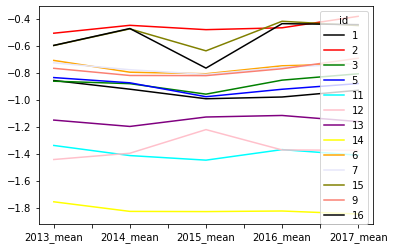

In [252]:
df7.plot(color=['black', 'red', 'green', 'blue', 'cyan', 'pink', 'purple',  'yellow', 'orange', 'lavender', 'olive', 'salmon'])

In [253]:
##issue that water pixels are coming out as moer positive, due to water pixels in mndwi having a negative value when water. speficially numbers 15 and 16 causing issues.

In [ ]:
import rasterio
with rasterio.open('test.tiff') as src:
    affine = src.transform
    array = src.read(1)
    array2 = src.read(2)
    array3 = src.read(3)
    array4 = src.read(4)
zs = zonal_stats(shpFile, array, stats='mean', affine=affine)
zs2 = zonal_stats(shpFile, array2, stats='mean', affine=affine)
zs3 = zonal_stats(shpFile, array3, stats='mean', affine=affine)
zs4 = zonal_stats(shpFile, array4, stats='mean', affine=affine)

In [ ]:
print(zs)

In [64]:
print(zs2)

[{'mean': -0.47428279630911224}]


In [65]:
print(zs3)

[{'mean': -0.4953022128002304}]


In [66]:
print(zs4)

[{'mean': -0.49436660696821144}]


In [61]:
import rasterio
with rasterio.open('test.tiff') as src2:
    affine2 = src2.transform
    array2 = src2.read(2)
zs2 = zonal_stats(shpFile, array, stats='mean', affine=affine)

In [62]:
print(zs2)

[{'mean': -0.43936056849946636}]


In [ ]:
import rasterio
with rasterio.open('test.tiff') as src2:
    affine2 = src2.transform
    array2 = src2.read(2)
zs2 = zonal_stats(shpFile, array, stats='mean', affine=affine)

In [139]:
print(createData)

[{'id': '0', 'type': 'Feature', 'properties': {'id': 1, 'mean': -0.43936056849946636}, 'geometry': {'type': 'Polygon', 'coordinates': (((1975434.205559892, 3880672.745187387), (1974116.203117608, 3881913.227038306), (1974116.203117608, 3881913.227038306), (1973206.8221390198, 3882789.8591889227), (1972963.9156963876, 3883708.832209846), (1973130.035027881, 3884098.329951805), (1974512.3707057647, 3884804.1941709653), (1976932.8068921263, 3881560.652509155), (1975434.205559892, 3880672.745187387)),)}, 'bbox': (1972963.9156963876, 3880672.745187387, 1976932.8068921263, 3884804.1941709653)}]


In [142]:
from geopandas import GeoDataFrame
dataGDF = shpFile
zonalGDF2 = GeoDataFrame.from_features(createData)
#append zonal statistics to the shapefile geodataframe
dataGDF = zonalGDF2.append(dataGDF,sort=False)

In [145]:
print(zonalGDF2)

                                            geometry  id      mean
0  POLYGON ((1975434.206 3880672.745, 1974116.203...   1 -0.439361


In [140]:
from osgeo import gdal
import sys

src_ds = gdal.Open( "INPUT.tif" )
if src_ds is None:
    print 'Unable to open INPUT.tif'
    sys.exit(1)

print "[ RASTER BAND COUNT ]: ", src_ds.RasterCount
for band in range( src_ds.RasterCount ):
    band += 1
    print "[ GETTING BAND ]: ", band
    srcband = src_ds.GetRasterBand(band)
    if srcband is None:
        continue

    stats = srcband.GetStatistics( True, True )
    if stats is None:
        continue

    print "[ STATS ] =  Minimum=%.3f, Maximum=%.3f, Mean=%.3f, StdDev=%.3f" % ( \
                stats[0], stats[1], stats[2], stats[3] )

SyntaxError: Missing parentheses in call to 'print'. Did you mean print('Unable to open INPUT.tif')? (<ipython-input-140-d73effc11ed7>, line 6)

In [63]:
df = ndbi_ds.to_dataframe()

In [64]:
print(df)

                     2013-07-02
x         y                    
1962645.0 3882525.0   -0.763843
          3882495.0   -0.772177
          3882465.0   -0.763733
          3882435.0   -0.746733
          3882405.0   -0.748027
...                         ...
1978905.0 3868995.0   -0.057692
          3868965.0   -0.037736
          3868935.0   -0.098901
          3868905.0   -0.118280
          3868875.0   -0.061728

[247608 rows x 1 columns]


In [171]:
for col in df.columns: 
    print(col) 

ndbi


ValueError: x and y arrays must be equal length.

In [178]:
output = xr.DataArray.to_array(ndbi_base, name = 'ndbi')

AttributeError: type object 'DataArray' has no attribute 'to_array'

In [163]:
print(output)

<xarray.Dataset>
Dimensions:  (time: 1, x: 543, y: 456)
Coordinates:
  * time     (time) datetime64[ns] 2013-07-02
  * y        (y) float64 3.883e+06 3.882e+06 3.882e+06 ... 3.869e+06 3.869e+06
  * x        (x) float64 1.963e+06 1.963e+06 1.963e+06 ... 1.979e+06 1.979e+06
Data variables:
    ndbi     (time, y, x) float64 -0.7638 -0.7473 -0.7264 ... -0.06329 -0.06173


In [177]:
write_geotiff_from_xr('param_thres.tiff', output, crs=output_projection, x_coord = 'x', y_coord = 'y')

ValueError: Source shape (1, 1, 456, 543) is inconsistent with given indexes 1

In [166]:
#df_zonal_stats = zonal_stats(shpFile, df, stat = "mean")
createData = zonal_stats(shpFile, ndbi_base, stats= 'mean std count min', affine='affine', geojson_out=True)
    #zonal_stats("polygons.shp", "elevation.tif",
     #       stats="count min mean max median")

TypeError: invalid path or file: <xarray.DataArray (time: 1, y: 456, x: 543)>
array([[[-0.76384288, -0.74727669, -0.72643739, ..., -0.46133333,
         -0.41036977, -0.28922306],
        [-0.77217692, -0.76021532, -0.74324324, ..., -0.5073804 ,
         -0.41579623, -0.4206278 ],
        [-0.76373333, -0.77323062, -0.76626757, ..., -0.52043693,
         -0.51449028, -0.5112485 ],
        ...,
        [-0.11666667, -0.09243697, -0.11173184, ..., -0.06024096,
         -0.04761905, -0.0989011 ],
        [-0.10364146, -0.10510511, -0.12166172, ..., -0.07042254,
          0.01234568, -0.11827957],
        [-0.04411765, -0.03731343, -0.10422535, ..., -0.01333333,
         -0.06329114, -0.0617284 ]]])
Coordinates:
  * time     (time) datetime64[ns] 2013-07-02
  * y        (y) float64 3.883e+06 3.882e+06 3.882e+06 ... 3.869e+06 3.869e+06
  * x        (x) float64 1.963e+06 1.963e+06 1.963e+06 ... 1.979e+06 1.979e+06

In [ ]:
gdf2 = pd.concat([shpFile, df_zonal_stats], axis=1) 

In [33]:
if is_dataset_empty(analysis_ds): raise Exception("DataCube Load returned an empty Dataset." +  
                                               "Please check load parameters for Analysis Dataset!")

NameError: name 'analysis_ds' is not defined

In [ ]:
print('broken')

> #### Clean Data
> Generating boolean masks that highlight valid pixels
> Pixels must be cloud-free over land or water to be considered

In [ ]:
def look_up_clean(platform, ds):
    if platform  in ["SENTINEL_2"]:
        good_quality = (
            (ds.scene_classification == 4) | # clear
            (ds.scene_classification == 5) | 
            (ds.scene_classification == 7) | 
            (ds.scene_classification == 2) | 
            (ds.scene_classification == 6)  #water
        )
    elif platform in ["LANDSAT_8"]:  
        good_quality = (
            (ds.pixel_qa == 322)  | # clear
            (ds.pixel_qa == 386)  |
            (ds.pixel_qa == 834)  |
            (ds.pixel_qa == 898)  |
            (ds.pixel_qa == 1346) |
            (ds.pixel_qa == 324)  | # water
            (ds.pixel_qa == 388)  |
            (ds.pixel_qa == 836)  |
            (ds.pixel_qa == 900)  |
            (ds.pixel_qa == 1348)
        )
    elif platform in ["LANDSAT_7", "LANDSAT_5", "LANDSAT_4"]:    
        good_quality = (
            (ds.pixel_qa == 66)  | # clear
            (ds.pixel_qa == 130) |
            (ds.pixel_qa == 68)  | # water
            (ds.pixel_qa == 132)  
        )
    else:
        print("invalid platform")
    return good_quality

In [ ]:
baseline_clean_mask = look_up_clean(platform_base, baseline_ds)
analysis_clean_mask = look_up_clean(platform_analysis, analysis_ds)

In [ ]:
#baseline_ds = baseline_ds.where(baseline_clean_mask)
#analysis_ds = analysis_ds.where(analysis_clean_mask)

In [ ]:
xx_data_b = baseline_ds[allmeasurements]
xx_data_a = analysis_ds[allmeasurements]

In [ ]:

xx_clean_b = odc.algo.keep_good_only(xx_data_b, where=baseline_clean_mask)

In [ ]:
xx_clean_a = odc.algo.keep_good_only(xx_data_a, where=analysis_clean_mask)

In [ ]:
scale, offset = (1/10_000, 0)  # differs per product, aim for 0-1 values in float32
xx_clean_b_32 = to_f32(xx_clean_b, scale=scale, offset=offset)
yy_b = xr_geomedian(xx_clean_b_32, 
                  num_threads=1,  # disable internal threading, dask will run several concurrently
                  eps=0.2*scale,  # 1/5 pixel value resolution
                  nocheck=True)   # disable some checks inside geomedian library that use too much ram

baseline_composite = from_float(yy_b, 
                dtype='int16', 
                nodata=-9999, 
                scale=1/scale, 
                offset=-offset/scale)

In [ ]:
#scale, offset = (1/10_000, 0)  # differs per product, aim for 0-1 values in float32
xx_clean_a_32 = to_f32(xx_clean_a, scale=scale, offset=offset)
yy_a = xr_geomedian(xx_clean_a_32, 
                  num_threads=1,  # disable internal threading, dask will run several concurrently
                  eps=0.2*scale,  # 1/5 pixel value resolution
                  nocheck=True)   # disable some checks inside geomedian library that use too much ram

analysis_composite = from_float(yy_a, 
                dtype='int16', 
                nodata=-9999, 
                scale=1/scale, 
                offset=-offset/scale)

>#### Mosaic
> Use clean masks in a time series composite

## Mask Water New

In [ ]:
#when S2 mask is ready - can remove the if statement. 
if platform_base in ["LANDSAT_8", "LANDSAT_7", "LANDSAT_5", "LANDSAT_4"]:   
    water_scenes_base = dc.load(product=baseline_water_product,
            measurements = ["water_classification"],
            time = baseline_time_period,
            platform = platform_base, 
            crs = crs,
               **query)
    #change clouds to no data value
    water_classes_base = water_scenes_base.where(water_scenes_base >= 0)
elif platform_base in ["SENTINEL_2"]:
    water_classes_base = dask.delayed(wofs_classify)(baseline_ds, clean_mask=baseline_clean_mask.values , no_data = np.nan , x_coord='x', y_coord = "y")
    water_classes_base = dask.delayed(water_classes_base.rename({'wofs': 'water_classification'}))
               

In [ ]:
#when S2 mask is ready - can remove the if statement. 
if platform_analysis in ["LANDSAT_8", "LANDSAT_7", "LANDSAT_5", "LANDSAT_4"]:   
    water_scenes_analysis = dc.load(product=analysis_water_product,
            measurements = ["water_classification"],
            time = analysis_time_period,
            platform = platform_analysis,  
            crs = crs,
               **query)
    #change clouds to no data value
    water_classes_analysis = water_scenes_analysis.where(water_scenes_analysis >= 0)
elif platform_analysis in ["SENTINEL_2"]:
    water_classes_analysis = dask.delayed(wofs_classify)(analysis_ds, clean_mask=analysis_clean_mask.values , no_data = np.nan , x_coord='x', y_coord = "y")
    water_classes_analysis = dask.delayed(water_classes_analysis.rename({'wofs': 'water_classification'}))
               

## mask water


In [36]:
water_composite_base = water_classes_base.water_classification.mean(dim='time')


In [37]:
water_composite_analysis = water_classes_analysis.water_classification.mean(dim='time')

In [38]:
baseline_composite = baseline_composite.rename({"y": "latitude", "x":"longitude"})
analysis_composite = analysis_composite.rename({"y": "latitude", "x":"longitude"})

>## Plot a spectral index using the cloud-filtered mosaic

# Spectral Parameter Anomaly

In [39]:
def createparametercomposite(indices, ds):
    '''Return the baseline_threshold_range based on indicies input.
    '''
    if indices in ['FC']:
        parameter_composite = frac_coverage_classify(ds, no_data = np.nan) 
    else:
        print('invalid indices')
    return parameter_composite

In [40]:
indices = 'FC'

In [41]:
parameter_baseline_composite = dask.delayed(createparametercomposite)(indices, baseline_composite)
parameter_analysis_composite = dask.delayed(createparametercomposite)(indices, analysis_composite)

## Apply water mask


In [42]:
frac_cov_baseline = parameter_baseline_composite.where(water_composite_base.values <= 0.4).where(parameter_baseline_composite !=-9999)

In [43]:
frac_cov_analysis = parameter_analysis_composite.where(water_composite_analysis.values <= 0.4).where(parameter_analysis_composite !=-9999)

In [44]:
#parameter_anomaly = parameter_analysis_composite - parameter_baseline_composite
parameter_anomaly = frac_cov_analysis - frac_cov_baseline

In [45]:
%%time
parameter_anomaly_output = parameter_anomaly.compute()

CPU times: user 26 s, sys: 7.31 s, total: 33.3 s
Wall time: 36.4 s


# Export Product

In [46]:
bs_output = parameter_anomaly_output.bs
pv_output = parameter_anomaly_output.pv
npv_output = parameter_anomaly_output.npv

In [47]:
write_geotiff_from_xr('land_change.tiff', parameter_anomaly_output, crs=output_projection, x_coord = 'longitude', y_coord = 'latitude')

In [48]:
write_geotiff_from_xr('bs_change.tiff', bs_output, crs=output_projection, x_coord = 'longitude', y_coord = 'latitude')
write_geotiff_from_xr('pv_change.tiff', pv_output, crs=output_projection, x_coord = 'longitude', y_coord = 'latitude')
write_geotiff_from_xr('npv_change.tiff', npv_output, crs=output_projection, x_coord = 'longitude', y_coord = 'latitude')